# 시계열 예측

- 시계열 데이터 분석의 목적
 - 1) 미래 시계열 값의 예측 (forecasting)
 - 2) 시계열 패턴을 분류 (정상, 고장, 위험 등)- 단변수 시계열 예측
- 베이스라인 모델
- Prophet 모델

- 시계열 예측: 과거 샘플 값을 보고 미래 값을 예측

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

- 선형 회귀 (linear regression) 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## 날씨 데이터

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(df.shape)
df[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


<AxesSubplot:>

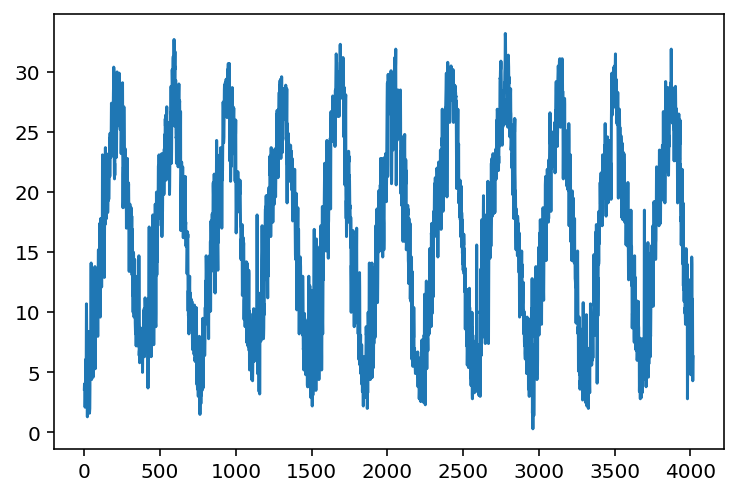

In [6]:
df["기온"].plot()

## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- train_test_split을 사용하려면 순서를 유지해야 한다 (shuiffling=False)
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다

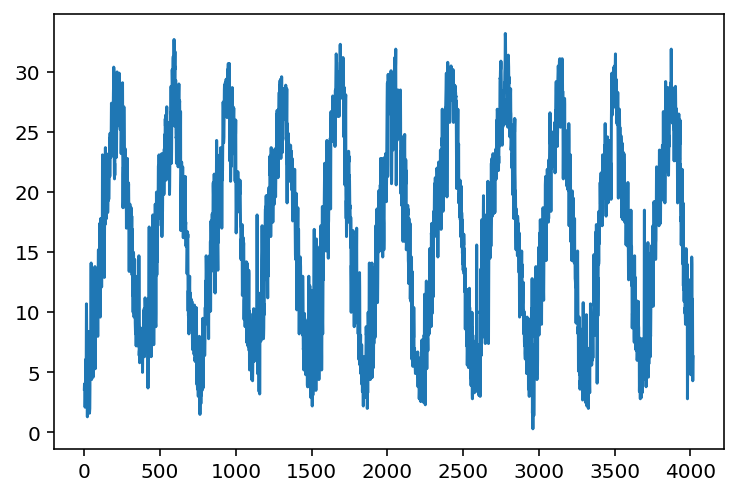

In [7]:
y = df["기온"].values
plt.plot(y)

In [8]:
y

array([3.6, 4. , 3.7, ..., 4.3, 6. , 6.3])

In [9]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누는 예
ratio = 0.75
cut = np.int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

<ipython-input-9-1c963954ae87>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut = np.int(len(y)*ratio)


(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 예측하는 것을 walk forward 예측이라고 한다

## 시계열 데이터를 테이블 구조로 만들기
- 시계열 예측에서 머신러닝 모델을 쉽게 적용하기 위해서 비정형인(크기가 일정치 않은) 시계열 데이터를 정형 데이터인 테이블 구조로 만드들어야 한다
- 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 보였다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - data는 입력 시계열 데이터 (위 그림에서 len(data)=13임)
 - n_steps는 한 샘플의 크기 (위 그림에서 5) - 윈도우

In [10]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

In [11]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
data = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(data, 7)

pd.DataFrame(list(zip(x_train, y_train)), columns=['X','y'])

,X,y
0,"[1, 2, 3, 4, 5, 6, 7]",8
1,"[2, 3, 4, 5, 6, 7, 8]",9
2,"[3, 4, 5, 6, 7, 8, 9]",10
3,"[4, 5, 6, 7, 8, 9, 10]",11
4,"[5, 6, 7, 8, 9, 10, 11]",12
5,"[6, 7, 8, 9, 10, 11, 12]",13


In [12]:
x_train, y_train

(array([[ 1,  2,  3,  4,  5,  6,  7],
        [ 2,  3,  4,  5,  6,  7,  8],
        [ 3,  4,  5,  6,  7,  8,  9],
        [ 4,  5,  6,  7,  8,  9, 10],
        [ 5,  6,  7,  8,  9, 10, 11],
        [ 6,  7,  8,  9, 10, 11, 12]]),
 array([ 8,  9, 10, 11, 12, 13]))

## 선형 회귀 예측 모델 

In [17]:
model = LinearRegression()

n_steps = 3
x_train, y_train = split_seq(train_data, n_steps) # 3000개
x_test, y_test = split_seq(test_data, n_steps) # 1000개
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
model.score(x_test, y_test).round(4) # R2 값

0.9318

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
 ### R-Squared
- 회귀 성능의 기본적인 평가 지표
- MSE를 분산으로 정규화한 값을 사용한다
- R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [18]:
# 선형 회귀 예측의 여러가지 성능 평가 지표 ****

def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("max error=", max(error).round(4))
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b*--', label='y_pred')
    plt.legend()
    plt.show()
    #  잔차  (residue) 산포도
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

MAE= 1.5505
max error= 8.5983
R2= 0.9318


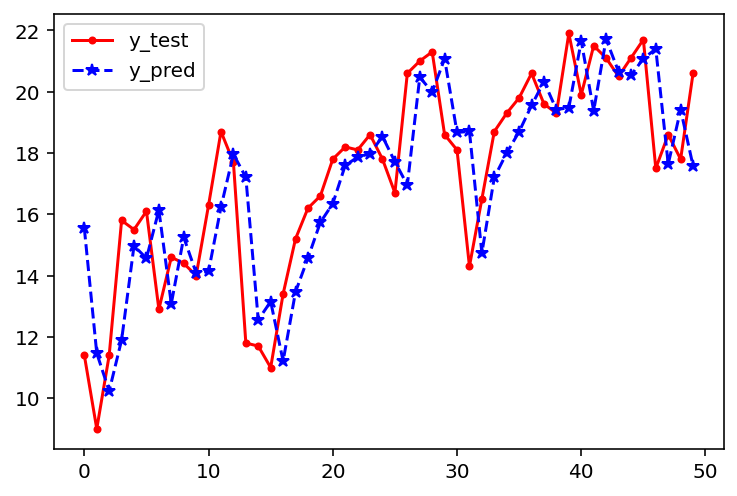

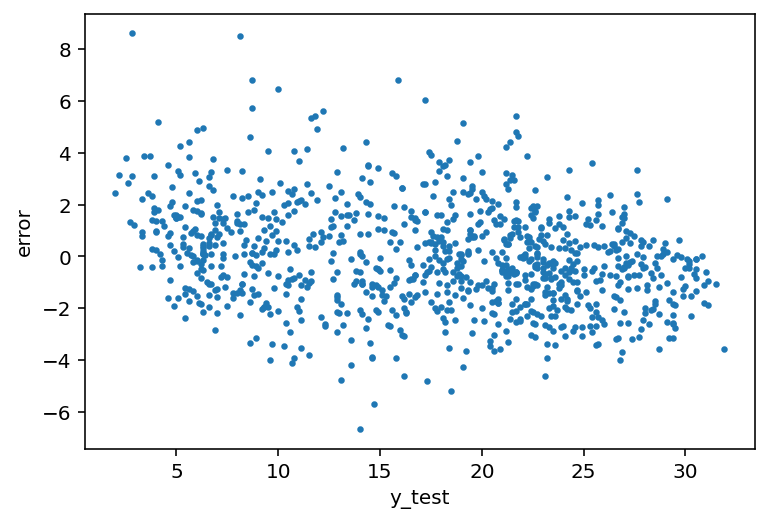

In [19]:
show_regression_result(y_test, y_pred,50)

MAE= 1.5505
max error= 8.5983
R2= 0.9318


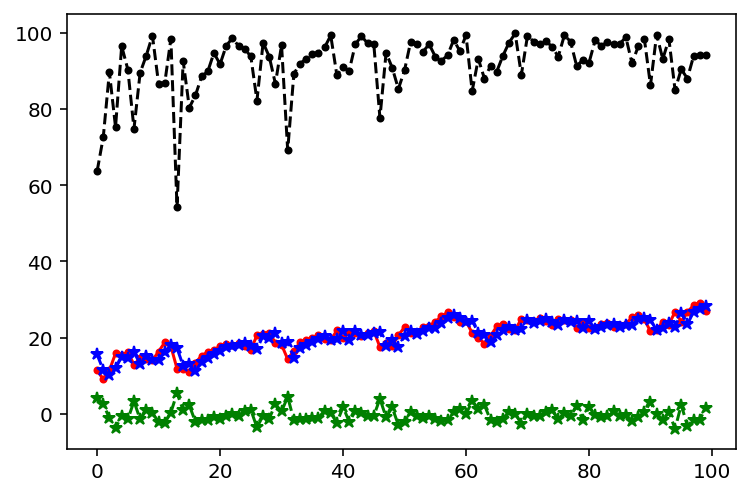

87.07595812852475

In [29]:
N=100
error = y_pred - y_test
print("MAE=", np.abs(error).mean().round(4))
print("max error=", max(error).round(4))
print("R2=",r2_score(y_test, y_pred).round(4)) # R2
plt.plot(y_test[:N], 'r.-', label='y_test')
plt.plot(y_pred[:N], 'b*--', label='y_pred')
plt.plot(error[:N], 'g*--', label='erroe')

ape = np.abs(error)*100/y_test
plt.plot(100-ape[:N], 'k.--', label='100-error')
plt.show()
100-ape.mean()
    #  잔차  (residue) 산포도
# plt.scatter(y_test, error, s=5)

In [16]:
# 과거 1일치만 사용했는데, 10일, 3일치를 사용하면 성능이 어떻게 되는가?
# R2 등을 관찰, 주의! R2는 퍼센트 오류를 나타내는 것이 아니다! 92% 맞추었다(x)
# MAPE (percentile error)? 100을 예측해야 하는데 95를 예측하면 95% 맞춘것임 (o) ??

# 베이스라인 모델
- 간단히 만들 수 있는 모델, 나이브 모델이라고도 한다
- 새로운 모델은 이것보다는 좋아야 하는 기준
- 종류
 - persistent 모델: 직전의 샘플 값으로 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다, ema)
 - 직전 값들이 아니라 주기적인 일정 간격을 두고 샘플을 취하여 평균을 얻기도 한다

## persistent 모델

In [15]:
# 현재 값으로 다음 값을 예측하는 경우
x_test, y_test = split_seq(test_data, 1) 

In [16]:
x_test[:5], y_test[:5]

(array([[15.2],
        [13.8],
        [15.3],
        [11.4],
        [ 9. ]]),
 array([13.8, 15.3, 11.4,  9. , 11.4]))

MAE= 1.5846
max error= 10.4
R2= 0.9266


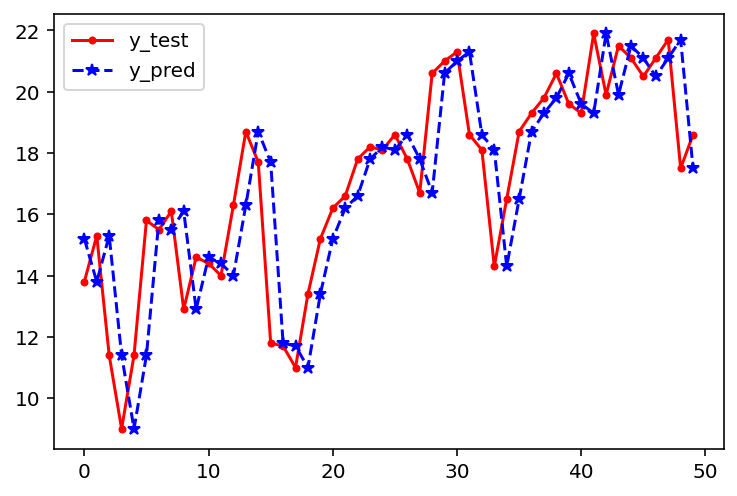

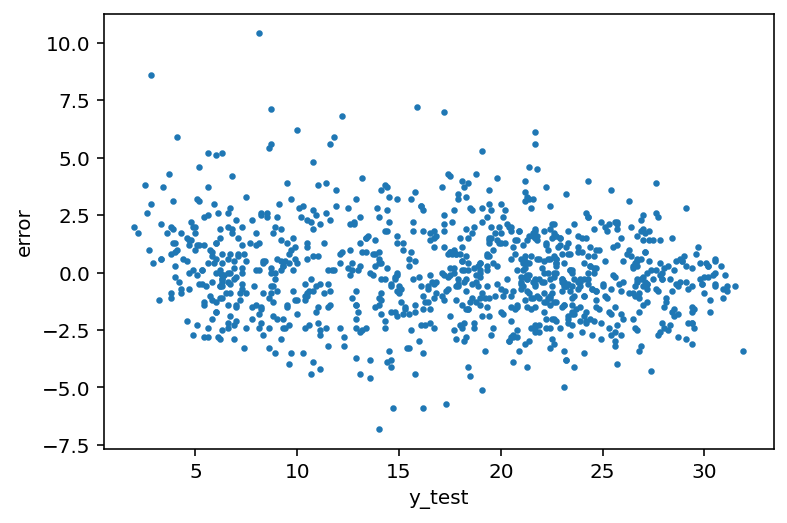

In [17]:
# 현재 값을 다음 예측값으로 사용
y_pred = x_test.ravel()
show_regression_result(y_test, y_pred, 50)

## 과거의 평균치로 예측하는 경우

In [31]:
# 입력 데이터의 평균치를 리턴하는 함수
def average_model(seq):
    return np.array(seq).mean(axis=1)

In [32]:
# 중요: 여러 시뮬레이션 결과를 볼 때, [] {}를 사용

In [35]:
result = []
for i in range(1,20): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result.append((i, r2_score(y_test, y_pred).round(4)))
result # 리스트 형태로 저장

[(1, 0.9266),
 (2, 0.9166),
 (3, 0.9113),
 (4, 0.9074),
 (5, 0.9037),
 (6, 0.901),
 (7, 0.8991),
 (8, 0.8982),
 (9, 0.8971),
 (10, 0.896),
 (11, 0.8948),
 (12, 0.8932),
 (13, 0.8913),
 (14, 0.8897),
 (15, 0.888),
 (16, 0.8861),
 (17, 0.8841),
 (18, 0.8812),
 (19, 0.8778)]

In [37]:
# 평균할 갯수 최적의 찾기
result = {}
for i in range(1,20): 
    n_steps=i
    x_test, y_test = split_seq(test_data, n_steps)
    y_pred = average_model(x_test)
    result[i]= r2_score(y_test, y_pred).round(4)

In [38]:
result # 데이터베이스

{1: 0.9266,
 2: 0.9166,
 3: 0.9113,
 4: 0.9074,
 5: 0.9037,
 6: 0.901,
 7: 0.8991,
 8: 0.8982,
 9: 0.8971,
 10: 0.896,
 11: 0.8948,
 12: 0.8932,
 13: 0.8913,
 14: 0.8897,
 15: 0.888,
 16: 0.8861,
 17: 0.8841,
 18: 0.8812,
 19: 0.8778}

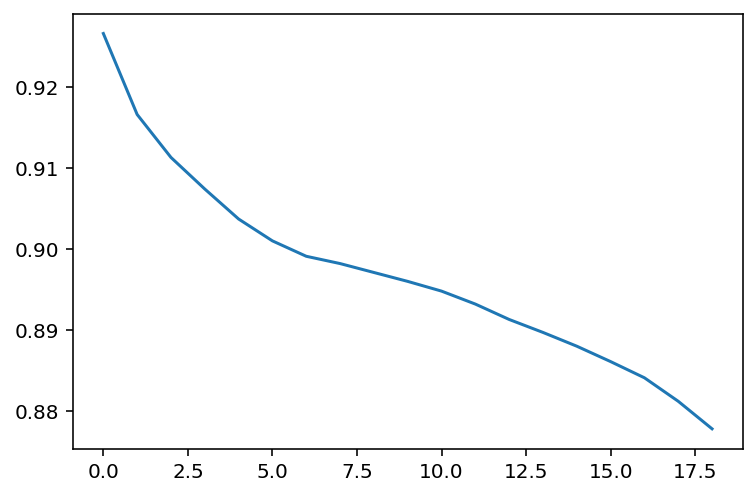

In [39]:
plt.plot(result.values())

In [41]:
max(result, key=result.get)

1

- 날씨 예측의 경우, 직전 값으로 예측하는 persistent 모델의 성능이 가장 좋다

# Prophet 

- fbprophet을 설치해야 함,  conda install -c conda-forge fbprophet
- PC에서 설치가 안되면 colab에서 실행한다
- 날짜와 값을 포함하는 데이터프레임을 입력으로 사용한다
- 반드시 ['ds', 'y'] 이름의 컬럼명을 사용해야 한다

In [23]:
# !mamba install -c conda-forge fbprophet  -y
!conda install -c conda-forge fbprophet
!pip install fbprophet
# 아나콘다가 설치되지 않았으면 파이썬과 쥬피터노트북만 따로 설치후에 
#   (파이썬  버전이 2.6 이하여야 한다)

In [42]:
from fbprophet import Prophet

In [43]:
df[:3]

,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


In [44]:
df = df.drop(["품질", "균질"], axis=1)
df.columns = ['ds', 'y'] # 컬러명이 ds, y로 고정되어 있다
df[:3]

,ds,y
0,2006/1/1,3.6
1,2006/1/2,4.0
2,2006/1/3,3.7


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      4018 non-null   object 
 1   y       4018 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.9+ KB


In [46]:
#datetime 포맷으로 바꾼다
df.ds = df.ds.apply(pd.to_datetime)
df.ds[:3]

0   2006-01-01
1   2006-01-02
2   2006-01-03
Name: ds, dtype: datetime64[ns]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4018 non-null   datetime64[ns]
 1   y       4018 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.9 KB


In [48]:
df[:10]

,ds,y
0,2006-01-01,3.6
1,2006-01-02,4.0
2,2006-01-03,3.7
3,2006-01-04,4.0
4,2006-01-05,3.6
5,2006-01-06,2.1
6,2006-01-07,2.8
7,2006-01-08,4.2
8,2006-01-09,3.7
9,2006-01-10,4.3


### 훈련, 검증 데이터 나누기

In [69]:
train = df[:3000]
test = df[3000:]
train.shape, test.shape

((3000, 2), (1018, 2))

In [70]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
# 예측할 기간의 날짜 정보가 필요하다
future_test = test.drop('y',axis=1)
future_test

,ds
3000,2014-03-20
3001,2014-03-21
3002,2014-03-22
3003,2014-03-23
3004,2014-03-24
...,...
4013,2016-12-27
4014,2016-12-28
4015,2016-12-29
4016,2016-12-30


In [72]:
forecast = model.predict(future_test)
forecast[:3]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-03-20,16.935624,7.876450,14.277975,16.935624,16.935624,-5.973643,-5.973643,-5.973643,0.063971,0.063971,0.063971,-6.037614,-6.037614,-6.037614,0.0,0.0,0.0,10.961981
1,2014-03-21,16.936083,7.709631,14.228123,16.936083,16.936083,-5.866160,-5.866160,-5.866160,0.075031,0.075031,0.075031,-5.941191,-5.941191,-5.941191,0.0,0.0,0.0,11.069923
2,2014-03-22,16.936541,8.191832,14.431051,16.936541,16.936541,-5.839034,-5.839034,-5.839034,0.008681,0.008681,0.008681,-5.847715,-5.847715,-5.847715,0.0,0.0,0.0,11.097507


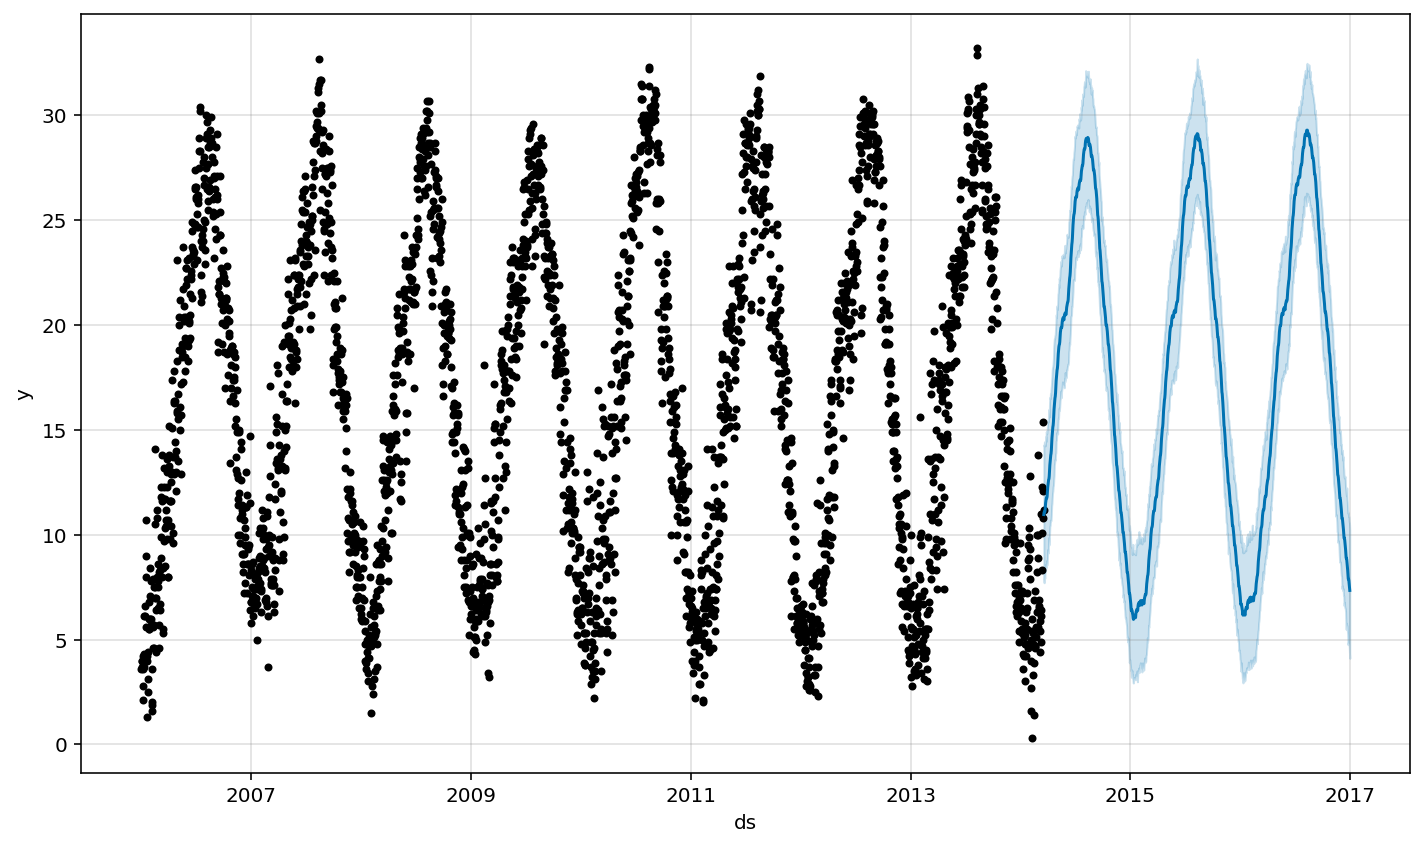

In [73]:
model.plot(forecast)
from datetime import datetime
# plt.xlim([datetime(2015, 7, 1), datetime(2015, 10, 1)])
plt.show()

In [74]:
y_test = test.y
y_test.shape

(1018,)

In [75]:
y_pred = forecast['yhat']
r2_score(y_test, y_pred)

0.8827511268723414

In [65]:
# 선형모델 0.93, 나이브모델의 0.926에 비해서 성능이 나쁘다?? 
# prophet 모델은 현재 값까지만 알려주고 모든 미래값을 한번에 예측한 것
# walk forward 모델이 아니다!
# 다른 장점: 결측치가 있어도 잘 동작한다, 특별한 이벤트를 반영할 수 있다